# Getting the data from the embeddings

In [9]:
import polars as pl
import numpy as np

embedding_cols = [f"emb_{i}" for i in range(1024)]

df = pl.scan_parquet("arxiv_embeddings_full.parquet")

# Convert to fixed-size Float32 array after concatenating
df_embeddings_only = df.select(
    pl.concat_arr(embedding_cols)
    .cast(pl.Array(pl.Float32, 1024))
    .alias("embeddings")
).collect()

df_embeddings_only.write_parquet("arxiv_embeddings_fixed.parquet")


In [10]:
# Free up memory
del df_embeddings_only
del df

## Reducing dimensions

In [1]:
import polars as pl

# Step 1: Define the names of the first 512 embedding columns you want to keep.
columns_to_keep = [f"emb_{i}" for i in range(512)]

# Step 2: Use scan_parquet for a memory-efficient lazy scan of the original file.
# The original file is the one with 1024 individual embedding columns.
df_lazy = pl.scan_parquet("arxiv_embeddings_full.parquet")

# Step 3: Select only the first 512 columns from the DataFrame.
# .collect() executes the plan and loads the result into memory.
df_first_512 = df_lazy.select(columns_to_keep).collect()

# Now, df_first_512 is a DataFrame with exactly 512 columns: emb_0, emb_1, ..., emb_511.
print("Shape of the resulting DataFrame:", df_first_512.shape)
print("Columns in the DataFrame:", df_first_512.columns)

# You can now proceed with operations like converting to a NumPy array for PCA.
embedding_array = df_first_512.to_numpy()

print("\nShape of the NumPy array:", embedding_array.shape)

Shape of the resulting DataFrame: (2765260, 512)
Columns in the DataFrame: ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82', 'emb_83', 'emb_84', 'emb_85', 'emb_86', 'emb_87', 'emb_88', 'emb_89', 'emb_90', 'emb_91', 'emb_92', 'emb

# Performing HDBSCAN clustering

In [3]:
# Perform clustering on the reduced embeddings with HDBSCAN
import fast_hdbscan

hdbscan_clusterer = fast_hdbscan.HDBSCAN(
    #min_cluster_size=10,
    min_samples=10,
    #metric='euclidean',
    #cluster_selection_method='eom'
)
hdbscan_labels = hdbscan_clusterer.fit_predict(embedding_array)

In [4]:
# Save the clustering results to a parquet file
import polars as pl 
df_clusters = pl.DataFrame({
    "cluster": hdbscan_labels,
    **{f"emb_{i}": embedding_array[:, i] for i in range(embedding_array.shape[1])}
})
df_clusters.write_parquet("arxiv_clusters.parquet")

### Findings: Too much noise in HDBSCAN

In [20]:
import evoc
import numpy as np
from numba import set_num_threads




set_num_threads(12)

#take a random sample of the embeddings
#embedding_array_sample = embedding_array[np.random.choice(embedding_array.shape[0], 10000, replace=False)]

#Perform the clustering using EVoC
clusterer = evoc.EVoC(
    noise_level= 0.0,
    #approx_n_clusters = 400,
    n_neighbors= 100,
    #min_num_clusters = 100
)

cluster_labelsEVoC = clusterer.fit_predict(embedding_array)
cluster_layersEVoC = clusterer.cluster_layers_

# The first layer is the finest, later layers are coarser
# You can check the noise level in each layer
for i, layer in enumerate(cluster_layersEVoC):
    noise = np.sum(layer == -1) / len(layer)
    print(f"Layer {i}: {noise:.2f} noise")
    print(f"Number of Clusters in Layer {i}: {len(set(layer)) - (1 if -1 in layer else 0)}")

Layer 0: 0.86 noise
Number of Clusters in Layer 0: 32556
Layer 1: 0.84 noise
Number of Clusters in Layer 1: 9511
Layer 2: 0.81 noise
Number of Clusters in Layer 2: 2750
Layer 3: 0.78 noise
Number of Clusters in Layer 3: 791
Layer 4: 0.73 noise
Number of Clusters in Layer 4: 242
Layer 5: 0.70 noise
Number of Clusters in Layer 5: 75
Layer 6: 0.70 noise
Number of Clusters in Layer 6: 25
Layer 7: 0.64 noise
Number of Clusters in Layer 7: 9
Layer 8: 0.47 noise
Number of Clusters in Layer 8: 4


In [21]:
from sklearn.metrics import silhouette_score
import numpy as np

# Sample 100,000 embeddings + labels for silhouette score
np.random.seed(69)
sample_size = 100_000
if embedding_array.shape[0] > sample_size:
    sample_idx = np.random.choice(embedding_array.shape[0], size=sample_size, replace=False)
else:
    sample_idx = np.arange(embedding_array.shape[0])

sample_embeddings = embedding_array[sample_idx]
sample_labels = cluster_labelsEVoC[sample_idx]

# Compute silhouette score
sil_score = silhouette_score(sample_embeddings, sample_labels)
print(f"Silhouette score (sample of 100,000): {sil_score:.4f}")


Silhouette score (sample of 100,000): 0.0014


In [22]:
import numpy as np

# Assume embedding_array and kmeans_labels are pre-existing variables
# Example placeholder data:
# embedding_array = np.random.rand(1000, 512)
# kmeans_labels = np.random.randint(0, 20, 1000)

cluster_coherence = {}
unique_labels = np.unique(cluster_labelsEVoC)

for cluster_id in unique_labels:
    indices = np.where(cluster_labelsEVoC == cluster_id)[0]
    n = len(indices)

    if n <= 1:
        cluster_coherence[cluster_id] = np.nan
        continue

    cluster_embeddings = embedding_array[indices]

    # --- Fast & Memory-Safe Calculation ---
    # 1. Normalize each embedding vector to have a length of 1.
    norms = np.linalg.norm(cluster_embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1e-9  # Avoid division by zero for zero-vectors
    normalized_embeddings = cluster_embeddings / norms

    # 2. Calculate the sum of all normalized vectors in the cluster.
    sum_vector = np.sum(normalized_embeddings, axis=0)

    # 3. Calculate the squared magnitude of the sum vector.
    # This is equivalent to the sum of all elements in the full similarity matrix.
    sum_of_all_similarities = np.dot(sum_vector, sum_vector)

    # 4. Calculate the sum of only the unique pairwise similarities.
    # We subtract n to remove the diagonal (where vectors are compared to themselves).
    sum_of_pairwise_similarities = (sum_of_all_similarities - n) / 2

    # 5. Calculate the number of unique pairs.
    num_pairs = (n * (n - 1)) / 2

    # 6. The average coherence is the total sum divided by the number of pairs.
    if num_pairs > 0:
        cluster_coherence[cluster_id] = sum_of_pairwise_similarities / num_pairs
    else:
        cluster_coherence[cluster_id] = np.nan # Should not happen due to n > 1 check


# --- Reporting (same as before) ---
total_docs = 0
weighted_sum_coherence = 0
for cluster_id, score in cluster_coherence.items():
    if not np.isnan(score):
        size = np.sum(cluster_labelsEVoC == cluster_id)
        weighted_sum_coherence += score * size
        total_docs += size

if total_docs > 0:
    overall_average_coherence = weighted_sum_coherence / total_docs
    print(f"Weighted Average Intra-Cluster Coherence: {overall_average_coherence:.4f}\n")

sorted_clusters = sorted(cluster_coherence.items(), key=lambda item: item[1], reverse=True)

for cluster_id, score in sorted_clusters:
    size = np.sum(cluster_labelsEVoC == cluster_id)
    if not np.isnan(score):
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): {score:.4f}")
    else:
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): NaN")

Weighted Average Intra-Cluster Coherence: 0.2599

Cluster  2 (Size: 251168): 0.3462
Cluster  1 (Size: 588715): 0.3083
Cluster  3 (Size: 353311): 0.2716
Cluster  0 (Size: 259757): 0.2575
Cluster -1 (Size: 1312309): 0.2190


### Findings: Too much noise in EVoC, silhouette is very low, coherence is low

# Performing K-Means clustering

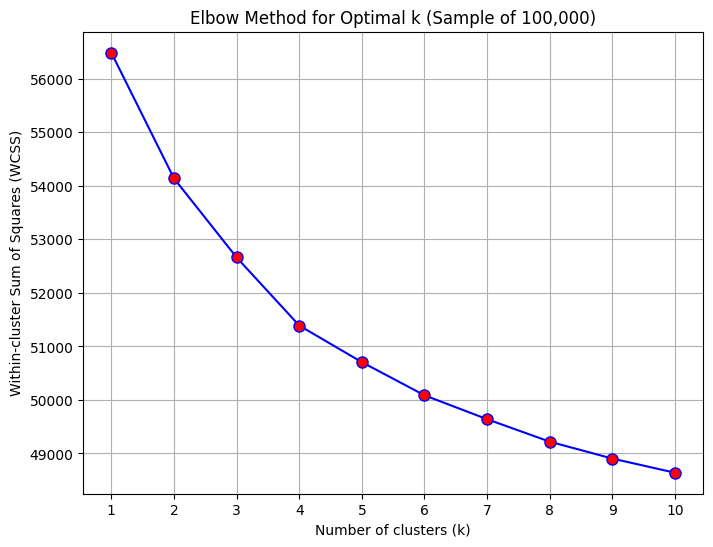

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Randomly sample 100,000 rows from the embedding array
np.random.seed(42)
sample_size = 100_000
if embedding_array.shape[0] > sample_size:
    indices = np.random.choice(embedding_array.shape[0], size=sample_size, replace=False)
    sample_embeddings = embedding_array[indices]
else:
    sample_embeddings = embedding_array  # Use all data if fewer than 100k rows

# Define the range of k values to test
k_values = range(1, 11)

# Initialize empty list to store WCSS values for each k
wcss = []

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sample_embeddings)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b', markerfacecolor='r', markersize=8)
plt.title('Elbow Method for Optimal k (Sample of 100,000)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


### Kmeans using K = 6

In [14]:
from sklearn.cluster import KMeans
from tqdm import tqdm

print("Running KMeans on full dataset with k=6...")
for _ in tqdm(range(1), desc="KMeans fitting"):
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans_labels = kmeans.fit_predict(embedding_array)


Running KMeans on full dataset with k=6...


KMeans fitting: 100%|██████████| 1/1 [02:43<00:00, 163.48s/it]


In [15]:
from sklearn.metrics import silhouette_score
import numpy as np

# Sample 100,000 embeddings + labels for silhouette score
np.random.seed(69)
sample_size = 100_000
if embedding_array.shape[0] > sample_size:
    sample_idx = np.random.choice(embedding_array.shape[0], size=sample_size, replace=False)
else:
    sample_idx = np.arange(embedding_array.shape[0])

sample_embeddings = embedding_array[sample_idx]
sample_labels = kmeans_labels[sample_idx]

# Compute silhouette score
sil_score = silhouette_score(sample_embeddings, sample_labels)
print(f"Silhouette score (sample of 100,000): {sil_score:.4f}")

Silhouette score (sample of 100,000): 0.0360


In [19]:
import numpy as np

# Assume embedding_array and kmeans_labels are pre-existing variables
# Example placeholder data:
# embedding_array = np.random.rand(1000, 512)
# kmeans_labels = np.random.randint(0, 20, 1000)

cluster_coherence = {}
unique_labels = np.unique(kmeans_labels)

for cluster_id in unique_labels:
    indices = np.where(kmeans_labels == cluster_id)[0]
    n = len(indices)

    if n <= 1:
        cluster_coherence[cluster_id] = np.nan
        continue

    cluster_embeddings = embedding_array[indices]

    # --- Fast & Memory-Safe Calculation ---
    # 1. Normalize each embedding vector to have a length of 1.
    norms = np.linalg.norm(cluster_embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1e-9  # Avoid division by zero for zero-vectors
    normalized_embeddings = cluster_embeddings / norms

    # 2. Calculate the sum of all normalized vectors in the cluster.
    sum_vector = np.sum(normalized_embeddings, axis=0)

    # 3. Calculate the squared magnitude of the sum vector.
    # This is equivalent to the sum of all elements in the full similarity matrix.
    sum_of_all_similarities = np.dot(sum_vector, sum_vector)

    # 4. Calculate the sum of only the unique pairwise similarities.
    # We subtract n to remove the diagonal (where vectors are compared to themselves).
    sum_of_pairwise_similarities = (sum_of_all_similarities - n) / 2

    # 5. Calculate the number of unique pairs.
    num_pairs = (n * (n - 1)) / 2

    # 6. The average coherence is the total sum divided by the number of pairs.
    if num_pairs > 0:
        cluster_coherence[cluster_id] = sum_of_pairwise_similarities / num_pairs
    else:
        cluster_coherence[cluster_id] = np.nan # Should not happen due to n > 1 check


# --- Reporting (same as before) ---
total_docs = 0
weighted_sum_coherence = 0
for cluster_id, score in cluster_coherence.items():
    if not np.isnan(score):
        size = np.sum(kmeans_labels == cluster_id)
        weighted_sum_coherence += score * size
        total_docs += size

if total_docs > 0:
    overall_average_coherence = weighted_sum_coherence / total_docs
    print(f"Weighted Average Intra-Cluster Coherence: {overall_average_coherence:.4f}\n")

sorted_clusters = sorted(cluster_coherence.items(), key=lambda item: item[1], reverse=True)

for cluster_id, score in sorted_clusters:
    size = np.sum(kmeans_labels == cluster_id)
    if not np.isnan(score):
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): {score:.4f}")
    else:
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): NaN")

Weighted Average Intra-Cluster Coherence: 0.3096

Cluster  4 (Size: 426113): 0.3626
Cluster  5 (Size: 460150): 0.3521
Cluster  2 (Size: 331861): 0.3369
Cluster  1 (Size: 451754): 0.2966
Cluster  0 (Size: 586018): 0.2738
Cluster  3 (Size: 509364): 0.2619


### Findings: Coherence is low, Silhouette is low.

# Graph-like clustering

In [8]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import time

# Assuming embedding_array is already (2_756_260, 1024) Matryoshka embeddings
matryoshka_64 = embedding_array[:, :512]  # Use first 512 dimensions only

# Optional: shuffle the data
np.random.seed(69)
shuffle_indices = np.random.permutation(len(matryoshka_64))
shuffled_embeddings = matryoshka_64[shuffle_indices]

# MiniBatchKMeans clustering
kmeans = MiniBatchKMeans(
    n_clusters=50,
    init="k-means++",
    max_iter=100,
    batch_size=10000,
    n_init=10,
    reassignment_ratio=0.01,
    random_state=69
)


labels = kmeans.fit_predict(shuffled_embeddings)

print("Cluster label distribution:", np.bincount(labels))

# Optional: restore original order
original_order_labels = np.empty_like(labels)
original_order_labels[shuffle_indices] = labels


Cluster label distribution: [53458 82567 47444 58857 34484 70904 63037 56418 47532 74448 37197 46135
 60601 78102 43773 41695 55765 72496 66343 41530 69399 48576 52442 35970
 53692 65243 62863 70175 62672 48556 69964 32123 67439 38122 64738 49921
 50055 78976 52721 51554 60841 67407 41931 40125 27155 52678 63761 67652
 29519 56204]


In [9]:
from sklearn.metrics import silhouette_score
import numpy as np

# Sample 100,000 embeddings + labels for silhouette score
np.random.seed(69)
sample_size = 100_000
if embedding_array.shape[0] > sample_size:
    sample_idx = np.random.choice(embedding_array.shape[0], size=sample_size, replace=False)
else:
    sample_idx = np.arange(embedding_array.shape[0])

sample_embeddings = embedding_array[sample_idx]
sample_labels = original_order_labels[sample_idx]

# Compute silhouette score
sil_score = silhouette_score(sample_embeddings, sample_labels)
print(f"Silhouette score (sample of 100,000): {sil_score:.4f}")

Silhouette score (sample of 100,000): 0.0193


In [10]:
import numpy as np



cluster_coherence = {}
unique_labels = np.unique(original_order_labels)

for cluster_id in unique_labels:
    indices = np.where(original_order_labels == cluster_id)[0]
    n = len(indices)

    if n <= 1:
        cluster_coherence[cluster_id] = np.nan
        continue

    cluster_embeddings = embedding_array[indices]

    # --- Fast & Memory-Safe Calculation ---
    # 1. Normalize each embedding vector to have a length of 1.
    norms = np.linalg.norm(cluster_embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1e-9  # Avoid division by zero for zero-vectors
    normalized_embeddings = cluster_embeddings / norms

    # 2. Calculate the sum of all normalized vectors in the cluster.
    sum_vector = np.sum(normalized_embeddings, axis=0)

    # 3. Calculate the squared magnitude of the sum vector.
    # This is equivalent to the sum of all elements in the full similarity matrix.
    sum_of_all_similarities = np.dot(sum_vector, sum_vector)

    # 4. Calculate the sum of only the unique pairwise similarities.
    # We subtract n to remove the diagonal (where vectors are compared to themselves).
    sum_of_pairwise_similarities = (sum_of_all_similarities - n) / 2

    # 5. Calculate the number of unique pairs.
    num_pairs = (n * (n - 1)) / 2

    # 6. The average coherence is the total sum divided by the number of pairs.
    if num_pairs > 0:
        cluster_coherence[cluster_id] = sum_of_pairwise_similarities / num_pairs
    else:
        cluster_coherence[cluster_id] = np.nan # Should not happen due to n > 1 check


# --- Reporting (same as before) ---
total_docs = 0
weighted_sum_coherence = 0
for cluster_id, score in cluster_coherence.items():
    if not np.isnan(score):
        size = np.sum(original_order_labels == cluster_id)
        weighted_sum_coherence += score * size
        total_docs += size

if total_docs > 0:
    overall_average_coherence = weighted_sum_coherence / total_docs
    print(f"Weighted Average Intra-Cluster Coherence: {overall_average_coherence:.4f}\n")

sorted_clusters = sorted(cluster_coherence.items(), key=lambda item: item[1], reverse=True)

for cluster_id, score in sorted_clusters:
    size = np.sum(original_order_labels == cluster_id)
    if not np.isnan(score):
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): {score:.4f}")
    else:
        print(f"Cluster {cluster_id:2d} (Size: {size:5d}): NaN")

Weighted Average Intra-Cluster Coherence: 0.3861

Cluster 44 (Size: 27155): 0.4761
Cluster 27 (Size: 70175): 0.4664
Cluster 13 (Size: 78102): 0.4520
Cluster 17 (Size: 72496): 0.4461
Cluster 47 (Size: 67652): 0.4447
Cluster 20 (Size: 69399): 0.4437
Cluster  8 (Size: 47532): 0.4367
Cluster  1 (Size: 82567): 0.4283
Cluster 18 (Size: 66343): 0.4274
Cluster 37 (Size: 78976): 0.4259
Cluster 24 (Size: 53692): 0.4247
Cluster  9 (Size: 74448): 0.4247
Cluster 43 (Size: 40125): 0.4228
Cluster 35 (Size: 49921): 0.4223
Cluster 29 (Size: 48556): 0.4197
Cluster 38 (Size: 52721): 0.4167
Cluster 21 (Size: 48576): 0.4098
Cluster  4 (Size: 34484): 0.4062
Cluster 25 (Size: 65243): 0.4045
Cluster 10 (Size: 37197): 0.4033
Cluster  3 (Size: 58857): 0.3985
Cluster 34 (Size: 64738): 0.3982
Cluster 49 (Size: 56204): 0.3956
Cluster 46 (Size: 63761): 0.3906
Cluster 41 (Size: 67407): 0.3874
Cluster  2 (Size: 47444): 0.3818
Cluster 39 (Size: 51554): 0.3817
Cluster 42 (Size: 41931): 0.3805
Cluster 32 (Size: 67439): 